In [19]:

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim

# Configuration
DATA_DIR = "data"  # Dossier contenant les dossiers 'piano' et 'panier'
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations des images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Chargement des données
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# Séparation des données en train et test
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.targets, random_state=42)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Chargement du modèle ResNet18
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))  # Adapter le nombre de classes
model = model.to(DEVICE)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Fonction d'entraînement
def train_model():
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    accuracy = correct / len(train_dataset)
    return total_loss / len(train_loader), accuracy

# Fonction de validation
def validate_model():
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / len(test_dataset)
    return total_loss / len(test_loader), accuracy

# Boucle d'entraînement
for epoch in range(EPOCHS):
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_accuracy = train_model()
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
    val_loss, val_accuracy = validate_model()
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Sauvegarde du modèle
torch.save(model.state_dict(), "piano_panier_model.pth")
print("Modèle sauvegardé sous 'piano_panier_model.pth'")

/home/emac/Documents/GSI_IA_SI/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emac/Documents/GSI_IA_SI/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Train Loss: 0.2601, Train Accuracy: 0.8980
Validation Loss: 0.3361, Validation Accuracy: 0.9406
Epoch 2/10
Train Loss: 0.1533, Train Accuracy: 0.9440
Validation Loss: 0.0763, Validation Accuracy: 0.9703
Epoch 3/10
Train Loss: 0.1027, Train Accuracy: 0.9614
Validation Loss: 0.0427, Validation Accuracy: 0.9802
Epoch 4/10
Train Loss: 0.1299, Train Accuracy: 0.9789
Validation Loss: 0.2295, Validation Accuracy: 0.9356
Epoch 5/10
Train Loss: 0.1879, Train Accuracy: 0.9229
Validation Loss: 0.9146, Validation Accuracy: 0.6782
Epoch 6/10
Train Loss: 0.1511, Train Accuracy: 0.9726
Validation Loss: 0.0581, Validation Accuracy: 0.9901
Epoch 7/10
Train Loss: 0.1056, Train Accuracy: 0.9689
Validation Loss: 0.0881, Validation Accuracy: 0.9703
Epoch 8/10
Train Loss: 0.2007, Train Accuracy: 0.9789
Validation Loss: 0.3207, Validation Accuracy: 0.8911
Epoch 9/10
Train Loss: 0.1115, Train Accuracy: 0.9602
Validation Loss: 0.1068, Validation Accuracy: 0.9554
Epoch 10/10
Train Loss: 0.2138, Train

/tmp/ipykernel_6673/3552529803.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("piano_panier_model.pth"))


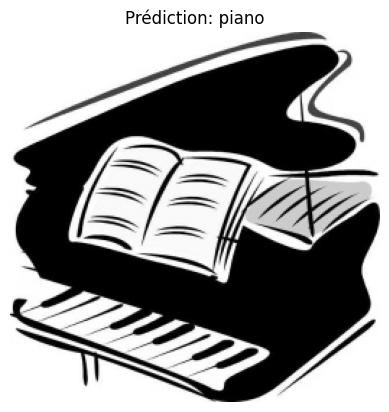

In [35]:
import matplotlib.pyplot as plt
from PIL import Image

# Fonction de test
def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_names = dataset.classes
    predicted_class = class_names[predicted.item()]
    return predicted_class, image

# Tester une image
TEST_IMAGE = "data/piano/piano_21.jpg"  # Remplacez par le chemin d'une image de test
model.load_state_dict(torch.load("piano_panier_model.pth"))
predicted_class, image = predict_image(TEST_IMAGE, model, transform)

# Afficher l'image et la prédiction
plt.imshow(image)
plt.title(f"Prédiction: {predicted_class}")
plt.axis("off")
plt.show()